<a href="https://colab.research.google.com/github/ajfrai/Pytorch-BiasDetection/blob/master/Deep_Fake_Facial_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Introduction**:

We will use this notebook to train a model on deep fake image data as found at __________ and we will show bais by showing that face data of different races results in more faces being inccorectly classified as 'Fake'.

### **Import dependencies**

In [ ]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

### **Create Dataset**

In [ ]:
from torchvision import datasets, transforms, models
import random

transforms = transforms.Compose([transforms.Resize(224), 
                                #  transforms.RandomRotation(45),transforms.RandomHorizontalFlip(),
                                #  transforms.RandomVerticalFlip(),transforms.ColorJitter(brightness=random.randint(0,20), contrast=random.randint(0,20), saturation=random.randint(0,20), hue=random.random()*0.5),
                                       transforms.ToTensor(),
                                       ])

data = datasets.ImageFolder("/content/drive/My Drive/Pytorch Summer Hackathon/real_and_fake_face/",       
                    transform=transforms)

Split Data into train and test

In [ ]:
from torch.utils.data import Dataset


class GenHelper(Dataset):
    def __init__(self, mother, length, mapping):
        # here is a mapping from this index to the mother ds index
        self.mapping=mapping
        self.length=length
        self.mother=mother

    def __getitem__(self, index):
        return self.mother[self.mapping[index]]

    def __len__(self):
        return self.length


def train_valid_split(ds, split_fold=10, random_seed=None):
    '''
    This is a pytorch generic function that takes a data.Dataset object and splits it to validation and training
    efficiently.
    :return:
    '''
    if random_seed!=None:
        np.random.seed(random_seed)

    dslen=len(ds)
    indices= list(range(dslen))
    valid_size=dslen//split_fold
    np.random.shuffle(indices)
    train_mapping=indices[valid_size:]
    valid_mapping=indices[:valid_size]
    train=GenHelper(ds, dslen - valid_size, train_mapping)
    valid=GenHelper(ds, valid_size, valid_mapping)

    return train, valid

In [ ]:
train_dataset,test_dataset = train_valid_split(data)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

1850
205


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

### **Visualize Deep Fake Image Data**

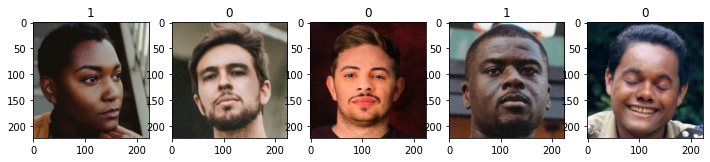

In [ ]:
import matplotlib.pyplot as plt

itr = iter(train_loader)
batch = next(itr)

_, axs = plt.subplots(1, 5, figsize=(12, 12))
axs = axs.flatten()
for img,label,ax in zip(batch[0][:5],batch[1][:5],axs):
    ax.set_title(label.item())
    ax.imshow(img.permute(1,2,0))
plt.show()

### **Build CNN**

While we can build our own architecture, it is more common to finetune one of the more common architectures as we don't have alot of data. We will choose Resnet50 as it is popular in Computer Vision and therefore would allow us to create a more realistic benchmark.

In [ ]:
import torch.nn as nn
model = models.resnet50(pretrained=True)


    
model.fc = nn.Sequential(nn.Linear(2048, 64),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(64, 2),
                                 nn.LogSoftmax(dim=1))
print(model)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

### **Training Loop**

In [ ]:
from tqdm.notebook import tqdm
import torch.nn as nn

model.to('cuda')
model.train()
final_results = []
final_labels = []
training_losses = []

ceLoss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(25)):
    total_loss = 0
    total_correct = 0
    for data in tqdm(train_loader): # Get Batch
        optimizer.zero_grad()

        batch = torch.tensor(data[0], dtype=torch.float32).to("cuda")

        label = torch.tensor(data[1]).to("cuda")
        
        preds = model(batch) # Pass Batch n
        loss = ceLoss(preds, label) # Calculate Loss

        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()

        for j,k in zip (preds,label.tolist()):
            if(torch.argmax(j)==k):
              total_correct+=1
            final_results.append(torch.argmax(j).item())
            final_labels.append(k)

    training_losses.append(total_loss)

    print("epoch", epoch, "total_correct:", total_correct, "loss:", total_loss)
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



epoch 0 total_correct: 995 loss: 11.653302133083344



epoch 1 total_correct: 1012 loss: 10.267102301120758



epoch 2 total_correct: 1090 loss: 9.95864713191986



epoch 3 total_correct: 1229 loss: 9.281763970851898



epoch 4 total_correct: 1291 loss: 8.673158764839172



epoch 5 total_correct: 1341 loss: 8.291205555200577



epoch 6 total_correct: 1378 loss: 7.634661167860031



epoch 7 total_correct: 1459 loss: 6.633560746908188



epoch 8 total_correct: 1494 loss: 6.408255010843277



epoch 9 total_correct: 1590 loss: 4.9459178894758224



epoch 10 total_correct: 1695 loss: 3.3059878051280975



epoch 11 total_correct: 1672 loss: 3.471528336405754



epoch 12 total_correct: 1686 loss: 3.5414323918521404



epoch 13 total_correct: 1719 loss: 2.9577787667512894



epoch 14 total_correct: 1707 loss: 3.010038785636425



epoch 15 total_correct: 1744 loss: 2.316764824092388



epoch 16 total_correct: 1813 loss: 1.0815343307331204



epoch 17 total_correct: 1816 loss: 0.8749793227761984



epoch 18 total_correct: 1809 loss: 0.9917364306747913



epoch 19 total_correct: 1791 loss: 1.4628093857318163



epoch 20 total_correct: 1792 loss: 1.5163819417357445



epoch 21 total_correct: 1793 loss: 1.3814568109810352



epoch 22 total_correct: 1825 loss: 0.9159005284309387



epoch 23 total_correct: 1830 loss: 0.5952144414186478



epoch 24 total_correct: 1819 loss: 0.9569900780916214



Visualize Training Results

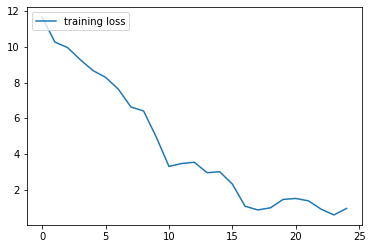

In [ ]:
import matplotlib.pyplot as plt
plt.plot(training_losses,label="training loss")
plt.legend(loc="upper left")
plt.show()

Confusion matrix, without normalization


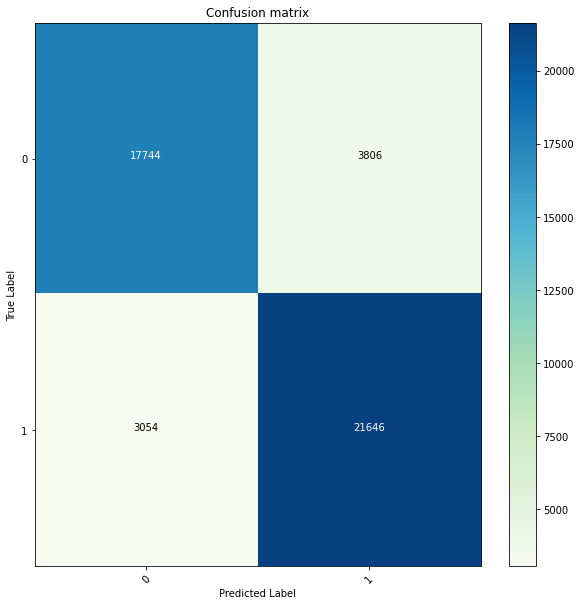

<Figure size 432x288 with 0 Axes>

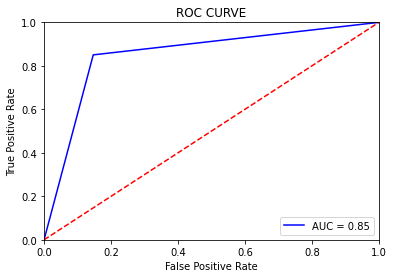

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(final_labels, final_results)
# Run helper methods below before procceding
plot_confusion_matrix(cm, classes={0,1},title='Confusion matrix')
plot_roc(final_results, final_labels)

### **Test Deep Fake Model**

In [ ]:
from tqdm.notebook import tqdm
test_correct = 0
final_results = []
final_labels = []
model = torch.load("/content/drive/My Drive/Pytorch Summer Hackathon/deepFakeModel.pth")
model.eval()
with torch.no_grad():
  for data in tqdm(test_loader): # Get Batch

          batch = torch.tensor(data[0], dtype=torch.float32).to("cuda")

          label = torch.tensor(data[1]).to("cuda")
          
          preds = model(batch) # Pass Batch n

          for j,k in zip (preds,label.tolist()):
              if(torch.argmax(j)==k):
                test_correct+=1
              final_results.append(torch.argmax(j).item())
              final_labels.append(k)

val_acc = test_correct/(len(test_loader)*128)*100
print("Test Accuracy:", val_acc,"%")  

KeyboardInterrupt: ignored

Print Confusion Matrix and ROC Curve

Confusion matrix, without normalization


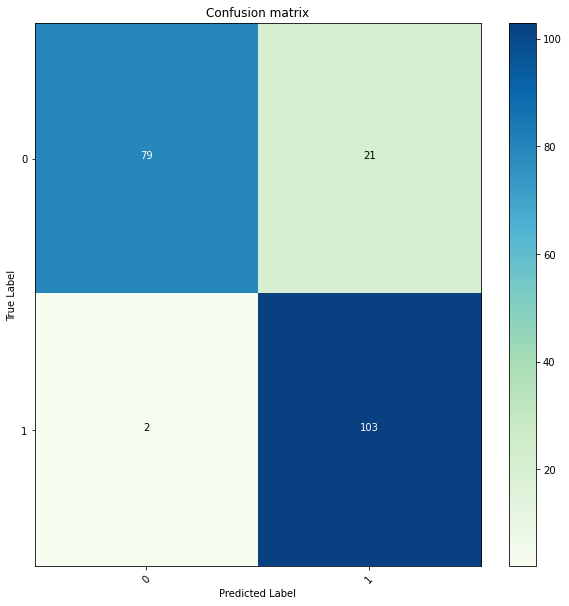

<Figure size 432x288 with 0 Axes>

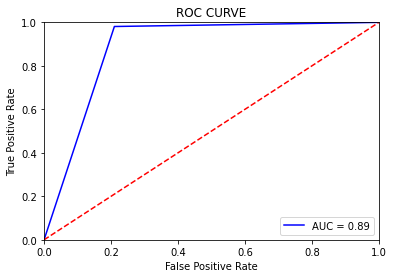

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(final_labels, final_results)
# Run helper methods below before procceding
plot_confusion_matrix(cm, classes={0,1},title='Confusion matrix')
plot_roc(final_labels, final_results)

### **Save Model**

In [ ]:
torch.save(model,"/content/drive/My Drive/Pytorch Summer Hackathon/deepFakeModel.pth")

### **Load Faces of people of different races**

For this part of the evaluation we are going to use the UTKFace dataset which has labels from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

In [ ]:
def get_img_label(imgpath):
  label = imgpath.split("_")
  return label[2]

In [ ]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm


class race_face_data(Dataset):

    def __init__(self, root_dir = '/content/drive/My Drive/Pytorch Summer Hackathon/UTKFace/', transform=None):
      self.root_dir = root_dir
      self.dataArray = os.listdir(root_dir)
      self.transform = transform

      # for img in tqdm(os.listdir(root_dir)):
      #     label = get_img_label(img)
      #     self.label.append(label)
      #     img = Image.open(root_dir+img)
      #     trans = transforms.ToPILImage()
      #     trans1 = transforms.ToTensor()
      #     data = trans(trans1(img))
      #     if transform != None:
      #       data = transform(data)
      #     self.dataArray.append(data)
          
        
    def __len__(self):
        return len(self.dataArray)

    def __getitem__(self, idx):
          img = self.dataArray[idx]
          label = get_img_label(img)
          img = Image.open(self.root_dir+img)
          trans = transforms.ToPILImage()
          trans1 = transforms.ToTensor()
          data = trans(trans1(img))
          if self.transform != None:
            data = self.transform(data)

          sample = {'data': data, 'label': label, 'fake': 0}

          return sample

In [ ]:
from torchvision import transforms
import torch
trans = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
adv_data_loader = torch.utils.data.DataLoader(race_face_data(transform=trans), batch_size=16)

### **Visualize Data and Distribution**

Example Images

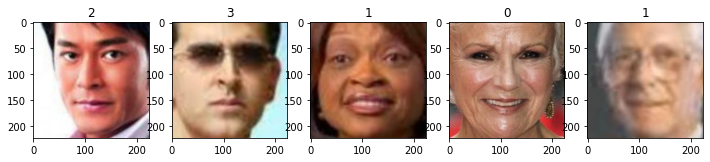

In [ ]:
import matplotlib.pyplot as plt

itr = iter(adv_data_loader)
batch = next(itr)

_, axs = plt.subplots(1, 5, figsize=(12, 12))
axs = axs.flatten()
for img,label,ax in zip(batch.get("data")[:5],batch.get("label")[:5],axs):
    ax.set_title(label)
    ax.imshow(img.permute(1,2,0))
plt.show()

### **Test Deepfake model with faces of different races**

In [ ]:
from tqdm.notebook import tqdm
test_correct = 0
final_results = []
final_labels = []
model = torch.load("/content/drive/My Drive/Pytorch Summer Hackathon/deepFakeModel.pth")
model.eval().to("cuda")
race_total = {0:0, 1:0, 2:0, 3:0, 4:0}
race_result = {0:0, 1:0, 2:0, 3:0, 4:0}
for data in tqdm(adv_data_loader): # Get Batch

        batch = torch.tensor(data.get("data"), dtype=torch.float32).to("cuda")

        # label = data.get("fake")
        
        preds = model(batch) # Pass Batch n

        for j,l in zip (preds,data.get("label")):
            if(torch.argmax(j)==0):
              test_correct+=1
              race_result.update({int(l):race_result.get(int(l))+1})
            race_total.update({int(l):race_total.get(int(l))+1})
            final_results.append(torch.argmax(j).item())
            final_labels.append(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
test_acc = test_correct/(len(adv_data_loader)*16)*100
print("Test Accuracy:", test_acc,"%")  

Test Accuracy: 0.992063492063492 %


### **Visualize Results**

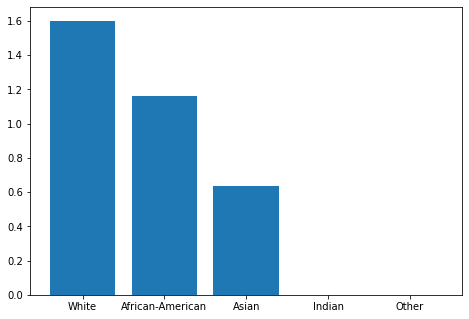

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
races = ['White', 'African-American', 'Asian', 'Indian', 'Other']
acc = [(race_result.get(0)/race_total.get(0)*100),(race_result.get(1)/race_total.get(1)*100),(race_result.get(2)/race_total.get(2)*100)
              ,(race_result.get(3)/race_total.get(3)*100)
              ,(race_result.get(4)/race_total.get(4)*100)]

ax.bar(races,acc)
plt.show()

### **Helper Methods**

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)  
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.autoscale()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.figure()
    plt.show()
    

In [ ]:
import sklearn as sk
def plot_roc(truth, result):
  fpr, tpr, threshold = sk.metrics.roc_curve(truth, result)
  roc_auc = sk.metrics.auc(fpr, tpr)
  import matplotlib.pyplot as plt
  plt.title('ROC CURVE')
  plt.plot(fpr, tpr, 'blue', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate',)
  plt.xlabel('False Positive Rate')
  plt.figure()
  plt.show()